In [ ]:
! pip install rdkit
! pip install torch_geometric
! pip install transformers
! pip install biopython
! pip install numpy
! pip install suds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 5.3 MB/s eta 0:00:00


# Import

In [ ]:
import pandas as pd
from os.path import join
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from rdkit import Chem
import rdkit
from rdkit.Chem import AllChem
from Bio.PDB import PDBList, PDBParser
import numpy as np
import requests
from sklearn.metrics import r2_score
import pickle
import torch
import networkx as nx
import numpy as np
from Bio.PDB import PDBParser, PDBList, NeighborSearch
from torch_geometric.data import Data
from scipy.spatial import KDTree
import logging
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader, Data
from torch_geometric.utils import to_networkx
import networkx as nx
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
# Define your inchi_to_graph function here
# and any other necessary functions or imports


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading data from Google Drive

In [ ]:
# Generate numbers from 200 to 3400 with a step of 200
data_train = []
# numbers = list(range(200, 3401, 200))
numbers = list(range(200, 3401, 200))
for number in numbers:

  file_path = '/content/drive/My Drive/kcat_minidatasets/trainNew' + str(number) + '.pkl'
  # Load the list from the specified file
  with open(file_path, 'rb') as file:
      data= pickle.load(file)

  data_train = data_train + data

In [ ]:
len(data_train)

3417

In [ ]:
def create_default_protein_graph():
    """Create a default protein graph with predefined nodes and edges."""
    graph = nx.Graph()
    # Define a few nodes with arbitrary features
    default_features = [
        [1] * 20 + [1.8, 8.1, 0, 0, 0, 0],  # Node 0 (ALA)
        [0] * 20 + [2.5, 5.5, 0, 1, 1, 1],  # Node 1 (CYS)
        [0] * 20 + [-3.5, 13.0, -1, 2, 2, 2],  # Node 2 (ASP)
        [0] * 20 + [4.5, 5.2, 0, 3, 3, 3]  # Node 3 (ILE)
    ]
    for idx, features in enumerate(default_features):
        graph.add_node(idx, feature=features)

    # Add some edges with arbitrary distances
    graph.add_edge(0, 1, weight=4.0)
    graph.add_edge(1, 2, weight=5.0)
    graph.add_edge(2, 3, weight=6.0)
    graph.add_edge(3, 0, weight=4.5)

    return graph_to_pyg_data(graph)

def graph_to_pyg_data(graph):
    try:
        node_features = [data['feature'] for _, data in graph.nodes(data=True)]
        x = torch.tensor(node_features, dtype=torch.float)

        edge_index = []
        edge_attr = []
        for edge in graph.edges(data=True):
            edge_index.append([edge[0], edge[1]])
            edge_index.append([edge[1], edge[0]])
            edge_attr.append([edge[2]['weight']])
            edge_attr.append([edge[2]['weight']])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        return data

    except Exception as e:
        logging.error(f"Error converting graph to PyG data: {e}")
        return None
x = create_default_protein_graph()
x

Data(x=[4, 26], edge_index=[2, 8], edge_attr=[8, 1])

In [ ]:
cleaned_data = []
for item in data_train:

  if item['protein_graph'] is None:
    # print(item['aggregated_substrate_graph'], item['aggregated_product_graph'], item['protein_graph'])
    item['protein_graph'] = create_default_protein_graph()
    cleaned_data.append(item)

  else:
    cleaned_data.append(item)

cleaned_complete_data_train = []
for item in cleaned_data:
  # if item['aggregated_substrate_graph'].edge_index.shape[1] == 12:
  if item['protein_graph'].edge_index.shape == torch.Size([0]):
    item['protein_graph'] = create_default_protein_graph()
    cleaned_data.append(item)

  else:
    cleaned_complete_data_train.append(item)

In [ ]:
len(cleaned_complete_data_train)

3417

In [ ]:
# Generate numbers from 200 to 3400 with a step of 200
data_test = []
# numbers = list(range(200, 3401, 200))
numbers = list(range(200, 801, 200))
for number in numbers:

  file_path = '/content/drive/My Drive/kcat_minidatasets/testNew' + str(number) + '.pkl'
  # Load the list from the specified file
  with open(file_path, 'rb') as file:
      data= pickle.load(file)

  data_test = data_test + data

file_path = '/content/drive/My Drive/kcat_minidatasets/testNew849.pkl'
  # Load the list from the specified file
with open(file_path, 'rb') as file:
    data= pickle.load(file)

data_test = data_test + data

cleaned_data = []
for item in data_test:

  if item['protein_graph'] is None:
    # print(item['aggregated_substrate_graph'], item['aggregated_product_graph'], item['protein_graph'])
    item['protein_graph'] = create_default_protein_graph()
    cleaned_data.append(item)

  else:
    cleaned_data.append(item)

cleaned_complete_data_test = []
for item in cleaned_data:
  # if item['aggregated_substrate_graph'].edge_index.shape[1] == 12:
  if item['protein_graph'].edge_index.shape == torch.Size([0]):
    item['protein_graph'] = create_default_protein_graph()
    cleaned_data.append(item)

  else:
    cleaned_complete_data_test.append(item)

In [ ]:
# Check if GPU is available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# PyTorch dataset

In [ ]:
import torch
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class KcatDataset(Dataset):
    def __init__(self, data_list, device):
        self.data_list = data_list
        self.device = device

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # combined_data = self.data_list[idx]['combined']
        combined_data = self.data_list[idx]['aggregated_substrate_graph']
        protein_data = self.data_list[idx]['protein_graph']
        log10_kcat = self.data_list[idx]['log10_kcat']
        protein_embedding = self.data_list[idx]['esm_embedding']
        fingerprint = self.data_list[idx]['fingerprint'][0]

        # Move data to the device
        combined_data = combined_data.to(self.device)
        protein_data = protein_data.to(self.device)
        protein_embedding = torch.tensor(protein_embedding).to(self.device)
        fingerprint = torch.tensor(fingerprint).to(self.device)

        return combined_data, protein_data, protein_embedding, fingerprint, log10_kcat


# data = cleaned_complete_data_train + cleaned_complete_data_test
# data_train, data_test = train_test_split(data, test_size=0.1,)

train_kcat_dataset = KcatDataset(cleaned_complete_data_train, device)
test_kcat_dataset = KcatDataset(cleaned_complete_data_test, device)

train_data_loader = DataLoader(train_kcat_dataset, batch_size=64, shuffle=True)
test_data_loader = DataLoader(test_kcat_dataset, batch_size=64)
test_data_loader_big = DataLoader(test_kcat_dataset, batch_size=854)



In [ ]:
cleaned_complete_data_train[100]['esm_embedding'].shape

(1280,)

# GAT combined architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Batch

class GATSection(nn.Module):
    def __init__(self, in_channels, out_channels, heads=1, concat=True, dropout=0.3):
        super(GATSection, self).__init__()
        self.gat1 = GATConv(in_channels, out_channels, heads=heads, concat=concat, dropout=dropout)
        self.gat2 = GATConv(out_channels * heads if concat else out_channels, out_channels, heads=heads, concat=concat, dropout=dropout)
        self.gat3 = GATConv(out_channels * heads if concat else out_channels, out_channels, heads=heads, concat=False, dropout=dropout)

    def forward(self, x, edge_index, batch):
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.elu(self.gat2(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.gat3(x, edge_index)
        x = global_mean_pool(x, batch)  # Pooling to get batch-wise embeddings
        return x

class ProteinGATModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ProteinGATModel, self).__init__()
        self.protein_gat = GATSection(in_channels, out_channels)

    def forward(self, protein_data):
        protein_x, protein_edge_index, protein_batch = protein_data.x, protein_data.edge_index, protein_data.batch
        protein_embedding = self.protein_gat(protein_x, protein_edge_index, protein_batch)
        return protein_embedding

class SubstrateGATModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SubstrateGATModel, self).__init__()
        self.substrate_gat = GATSection(in_channels, out_channels)

    def forward(self, substrate_data):
        substrate_x, substrate_edge_index, substrate_batch = substrate_data.x, substrate_data.edge_index, substrate_data.batch
        substrate_embedding = self.substrate_gat(substrate_x, substrate_edge_index, substrate_batch)
        return substrate_embedding

class CombinedModel(nn.Module):
    def __init__(self, protein_in_channels, substrate_in_channels, esm_embedding_dim, substrate_embedding_dim, reaction_fingerprint_dim, hidden_dim, final_out_dim):
        super(CombinedModel, self).__init__()
        self.protein_gat_model = ProteinGATModel(protein_in_channels, hidden_dim)
        self.substrate_gat_model = SubstrateGATModel(substrate_in_channels, hidden_dim)

        # Calculate the correct combined dimension
        combined_dim = 3584 #hidden_dim + hidden_dim + esm_embedding_dim + reaction_fingerprint_dim + substrate_embedding_dim
        # Ensure the fc1 layer takes the correct input dimension
        self.fc1 = nn.Linear(combined_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, final_out_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, protein_data, substrate_data, esm_embeddings, reaction_fingerprint):
        # Get embeddings from both GNNs
        protein_embedding = self.protein_gat_model(protein_data)
        substrate_embedding = self.substrate_gat_model(substrate_data)

        # Ensure esm_embeddings and reaction_fingerprint are batch-wise and match the batch size
        if esm_embeddings.dim() == 2 and esm_embeddings.size(0) == protein_embedding.size(0) == substrate_embedding.size(0):
            # Concatenate embeddings correctly
            combined_embedding = torch.cat([protein_embedding, substrate_embedding, esm_embeddings, reaction_fingerprint], dim=-1)
        else:
            raise ValueError("Mismatch in batch size between embeddings and data")

        # Pass through linear layers
        x = F.relu(self.fc1(combined_embedding))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Define input parameters
protein_in_channels = 26  # Example input channel size for proteins
substrate_in_channels = 6  # Example input channel size for substrates
hidden_dim = 128  # Hidden dimension for the GCN and linear layers
esm_embedding_dim = 1280  # ESM embedding dimension for proteins
substrate_embedding_dim = 2048  # Embedding dimension for substrates
reaction_fingerprint_dim = 512  # Example dimension for reaction fingerprints
final_out_dim = 1  # Final output dimension

# Create an instance of the combined model
combined_model = CombinedModel(
    protein_in_channels=protein_in_channels,
    substrate_in_channels=substrate_in_channels,
    esm_embedding_dim=esm_embedding_dim,
    substrate_embedding_dim=substrate_embedding_dim,
    reaction_fingerprint_dim=reaction_fingerprint_dim,
    hidden_dim=hidden_dim,
    final_out_dim=final_out_dim
)

combined_model = combined_model.to(device)

optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.0005, weight_decay=0.003)


In [ ]:
len(cleaned_complete_data_train), len(cleaned_complete_data_test)

(3417, 854)

In [ ]:

# Example instantiation of the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def plot_loss(train_scores, test_scores):
    plt.figure()
    plt.plot(train_scores, label='Train Loss')
    plt.plot(test_scores, label='Test Loss')
    plt.title('Combined GAT train and test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_r2(train_r2, test_r2):
    plt.figure()
    plt.plot(train_r2, label='Train R2 Score')
    plt.plot(test_r2, label='Test R2 Score')
    plt.title('Combined GAT train and test loss')
    plt.xlabel('Epochs')
    plt.ylabel('R2 Score')
    plt.legend()
    plt.show()




# Training function

In [ ]:
import copy

def train_model(train_data_loader, test_data_loader, device, model, optimizer, model_type, epochs, print_out=True):
    train_scores = []
    test_scores = []
    test_r2_score = []
    train_r2_score = []
    best_test_loss = float('inf')
    best_test_r2 = -1000
    best_model_state = None


    for epoch in range(epochs):
        model.train()
        train_total_loss = 0
        all_outputs = []
        all_targets = []

        for mol_batch, prot_batch, esm_embedding, fingerprint, targets in train_data_loader:


            targets = torch.tensor(targets).float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            # protein_data, substrate_data, esm_embeddings, reaction_fingerprint

            output = model(prot_batch, mol_batch, esm_embedding, fingerprint.float())


            if output is not None:
                loss = F.mse_loss(output, targets)
                loss.backward()
                optimizer.step()
                train_total_loss += loss.item()
                all_outputs.extend(output.detach().cpu().numpy())
                all_targets.extend(targets.detach().cpu().numpy())

        r2 = r2_score(all_targets, all_outputs)
        train_r2_score.append(r2)
        if print_out:
          print(f"Epoch {epoch}, Train Loss: {train_total_loss / len(train_data_loader)}, Train R2: {r2}")

        model.eval()
        total_test_loss = 0
        all_outputs = []
        all_targets = []

        with torch.no_grad():
            for mol_batch, prot_batch, esm_embedding, fingerprint, targets in test_data_loader:


                targets = torch.tensor(targets).float().unsqueeze(1).to(device)

                output = model(prot_batch, mol_batch, esm_embedding, fingerprint.float())


                if output is not None:
                    loss = F.mse_loss(output, targets)
                    total_test_loss += loss.item()
                    all_outputs.extend(output.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())

        average_test_loss = total_test_loss / len(test_data_loader)
        test_scores.append(average_test_loss)
        if print_out:
          print(f"Epoch {epoch}, Test Loss: {average_test_loss}")

        r2 = r2_score(all_targets, all_outputs)
        test_r2_score.append(r2)

        if print_out:
          print(f"Epoch {epoch}, Test R2: {r2}")

        if r2 > best_test_r2:
            best_test_r2 = r2
            best_model_state = copy.deepcopy(model.state_dict())


        train_scores.append(train_total_loss / len(train_data_loader))


    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    if print_out:
      plot_loss(train_scores, test_scores)
      plot_r2(train_r2_score, test_r2_score)
      print("Best test r2")
    return model, best_test_r2



Epoch 0, Train Loss: 1.5898416307237413, Train R2: -0.14709179128321215
Epoch 0, Test Loss: 1.3968633711338043
Epoch 0, Test R2: 0.0257766296773132
Epoch 1, Train Loss: 1.3535035815503862, Train R2: 0.026727332270901627
Epoch 1, Test Loss: 1.3052126850400652
Epoch 1, Test R2: 0.08903295476516404
Epoch 2, Train Loss: 1.3879257517832297, Train R2: 0.001996771163878197
Epoch 2, Test Loss: 1.3428698948451452
Epoch 2, Test R2: 0.058681927305711756
Epoch 3, Train Loss: 1.1589967696755021, Train R2: 0.17432206709171882
Epoch 3, Test Loss: 1.2297183190073286
Epoch 3, Test R2: 0.1419133071175981
Epoch 4, Train Loss: 1.216490297957703, Train R2: 0.1314153589005198
Epoch 4, Test Loss: 1.1638190703732627
Epoch 4, Test R2: 0.18967388306321742
Epoch 5, Train Loss: 1.551707864911468, Train R2: -0.11956604113599156
Epoch 5, Test Loss: 1.1028128053460802
Epoch 5, Test R2: 0.23069749532976502
Epoch 6, Train Loss: 1.165741166582814, Train R2: 0.16250634160882127
Epoch 6, Test Loss: 1.055658268077033
Epoc

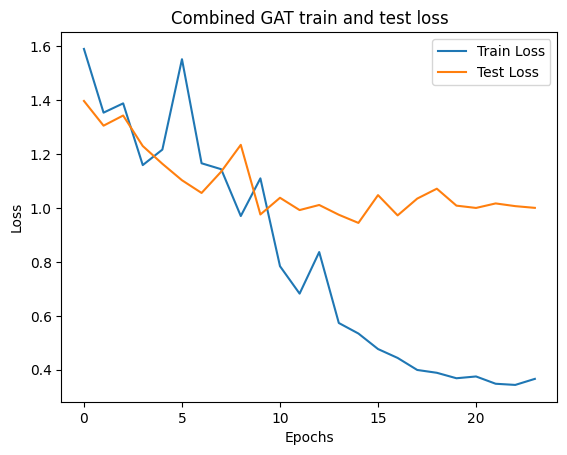

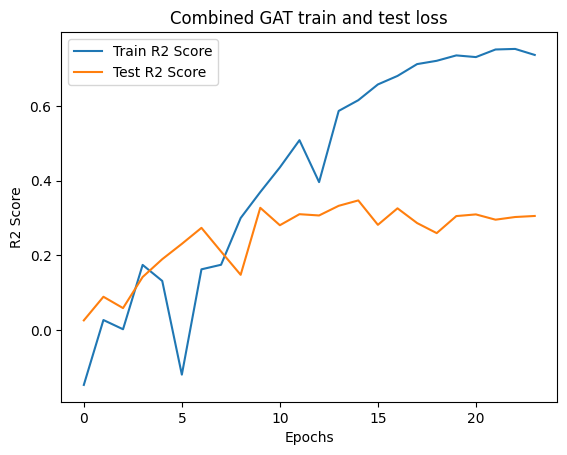

Best test r2


In [ ]:
# Train protein model
trained_model, r2 = train_model(train_data_loader, test_data_loader, device, combined_model, optimizer, model_type='protein', epochs=24, print_out=True)


# 10 training runs statistics

In [ ]:
def get_default_models():
  # Define input parameters
  protein_in_channels = 26  # Example input channel size for proteins
  substrate_in_channels = 6  # Example input channel size for substrates
  hidden_dim = 128  # Hidden dimension for the GCN and linear layers
  esm_embedding_dim = 1280  # ESM embedding dimension for proteins
  substrate_embedding_dim = 2048  # Embedding dimension for substrates
  reaction_fingerprint_dim = 512  # Example dimension for reaction fingerprints
  final_out_dim = 1  # Final output dimension

  # Create an instance of the combined model
  combined_model = CombinedModel(
      protein_in_channels=protein_in_channels,
      substrate_in_channels=substrate_in_channels,
      esm_embedding_dim=esm_embedding_dim,
      substrate_embedding_dim=substrate_embedding_dim,
      reaction_fingerprint_dim=reaction_fingerprint_dim,
      hidden_dim=hidden_dim,
      final_out_dim=final_out_dim
  )

  combined_model = combined_model.to(device)

  optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.0005, weight_decay=0.003)
  return combined_model, optimizer

In [ ]:
results = []
for i in range(10):
  combined_model, optimizer = get_default_models()
  trained_model, r2 = train_model(train_data_loader, test_data_loader, device, combined_model, optimizer, model_type='protein', epochs=18, print_out=False)
  results.append(r2)

In [ ]:
import statistics
print("10 times avg test results")
print("Mean:", statistics.mean(results))
print("Standard Deviation: ", statistics.stdev(results))

10 times avg test results
Mean: 0.36103948371481903
Standard Deviation:  0.008614181086406068


In [ ]:
results

[0.36783607389275164,
 0.3673240663913443,
 0.3687253932532344,
 0.3527327961576575,
 0.35880794496500057,
 0.3571444505862075,
 0.3593169417786767,
 0.3737884049601613,
 0.3446869756006661,
 0.3600317895624905]